<a href="https://colab.research.google.com/github/arssite/Datalysis/blob/main/EV_RMSE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install xgboost lightgbm catboost shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt


In [8]:
# Unzip
with ZipFile('/content/Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Read CSVs
train_df = pd.read_csv('/content/Dataset/Train.csv')
test_df = pd.read_csv('/content/Dataset/Test.csv')
submission_df = pd.read_csv('/content/Dataset/submission.csv')

# Drop irrelevant columns
drop_cols = ['ID', 'Model_Name'] if 'Model_Name' in train_df.columns else ['ID']
train_df.drop(columns=drop_cols, inplace=True, errors='ignore')
test_df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Handle missing values
train_df.fillna(train_df.median(numeric_only=True), inplace=True)
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

# Encode categoricals
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

# Align
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# Split features/target
X = train_df.drop('Electric_Range', axis=1)
y = train_df['Electric_Range']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#Drop 'Electric_Range' from test_df before scaling if it exists
#This ensures the scaler is applied to the same columns used during training.
if 'Electric_Range' in test_df.columns:
    test_df = test_df.drop(columns=['Electric_Range'])
#One-hot encoding might create multiple columns related to 'Electric_Range',
#so we remove any column containing "Electric_Range"
test_df = test_df[[col for col in test_df.columns if 'Electric_Range' not in col]]


test_scaled = scaler.transform(test_df)

In [10]:
def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    # Calculate MSE and then take the square root for RMSE if squared is not supported
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    print(f"{name} Validation RMSE: {rmse:.4f}")
    return model, rmse

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model("Random Forest", rf, X_train, y_train, X_val, y_val)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
evaluate_model("XGBoost", xgb_model, X_train_scaled, y_train, X_val_scaled, y_val)

# LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
evaluate_model("LightGBM", lgb_model, X_train_scaled, y_train, X_val_scaled, y_val)

# CatBoost (no need to scale)
cat_model = CatBoostRegressor(verbose=0, random_state=42)
evaluate_model("CatBoost", cat_model, X_train, y_train, X_val, y_val)


Random Forest Validation RMSE: 1.1415
XGBoost Validation RMSE: 1.1828


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2119
[LightGBM] [Info] Number of data points in the train set: 7432, number of used features: 349
[LightGBM] [Info] Start training from score 110.066604


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Validation RMSE: 2.5591
CatBoost Validation RMSE: 1.0760


(<catboost.core.CatBoostRegressor at 0x7b2deb56e150>,
 np.float64(1.0759634919646353))

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


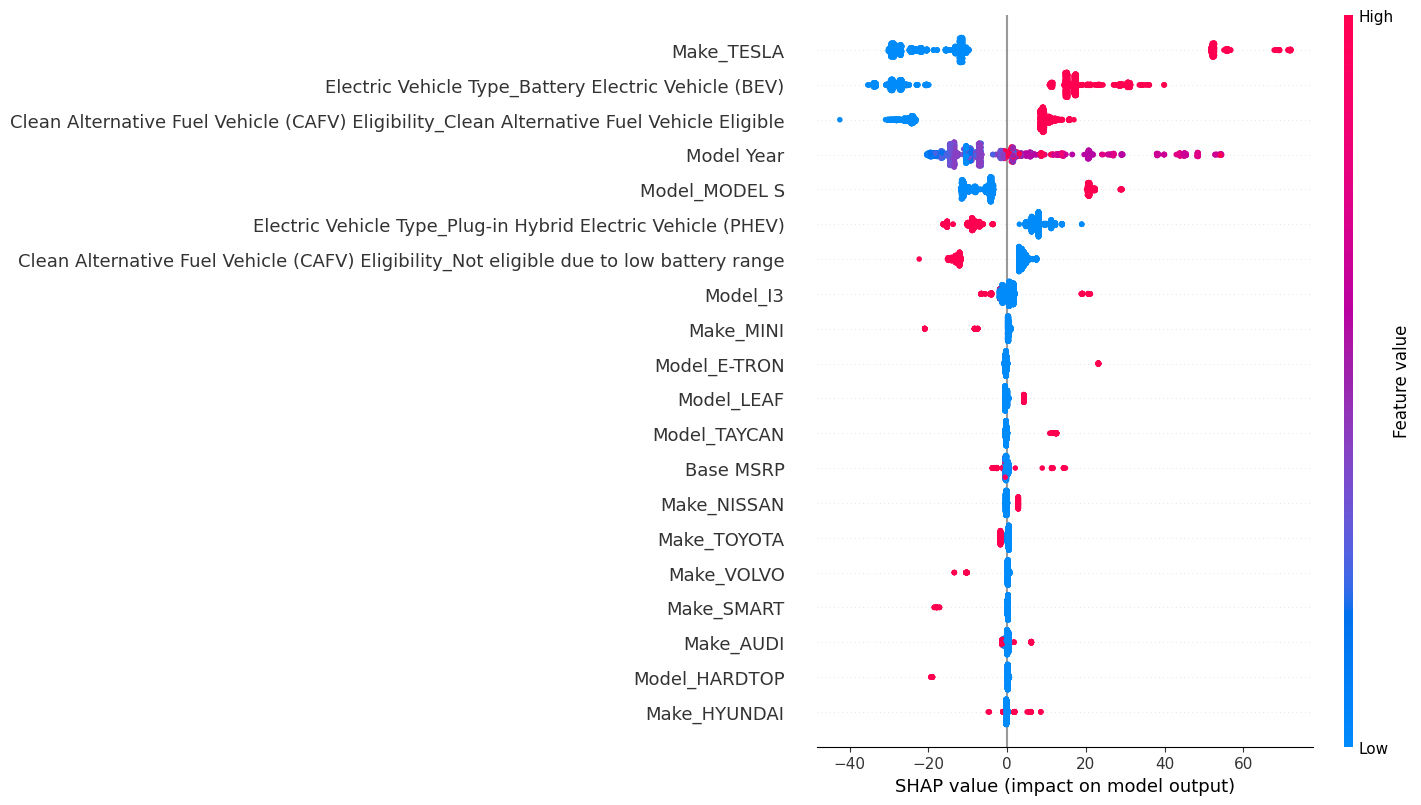

In [11]:
# SHAP for CatBoost (also works for XGBoost/LightGBM)
explainer = shap.Explainer(cat_model)
shap_values = explainer(X_val)

# SHAP summary plot
shap.summary_plot(shap_values, X_val)


In [12]:
# Pick best model (replace with best from eval)
final_model = cat_model
final_model.fit(X, y)
test_preds = final_model.predict(test_df)

submission_df['Electric_Range'] = test_preds
submission_df.to_csv('final_submission.csv', index=False)
